In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(zellkonverter)
library(loomR)
library(Seurat)
library(SeuratDisk)
library(data.table)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
adata_loom <- connect(filename = "/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_Immune_cell_scvi_adata_diet.loom", mode = "r+",skip.validate = TRUE)

matrix=adata_loom[["matrix"]][,]
matrix=t(matrix)
dim(matrix)

gene = adata_loom$row.attrs$var_names[]
barcode = adata_loom$col.attrs$obs_names[]
meta_data = read.csv('/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_Immune_cell_scvi_adata_diet_obs.csv',row.names = 1) # 这个直接给个dataframe吧
meta_feature = read.csv('/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_Immune_cell_scvi_adata_diet_var.csv',row.names = 1)


colnames(matrix)= barcode
row.names(matrix)= gene
x_scvi = adata_loom$col.attrs$X_scVI[,]
x_umap = adata_loom$col.attrs$X_umap[,]


seurat_object_MuSC= CreateSeuratObject(counts = matrix,meta.data = meta_data,
                                       project = 'musc_loom',
                                       min.cells = 0, 
                                       min.features = 0)

seurat_object_MuSC@assays[["RNA"]]@meta.features <- meta_feature
# seurat_object_MuSC@reductions[["scVI"]]@cell.embeddings <- x_scvi

x_scvi = t(x_scvi)
x_umap = t(x_umap)
rownames(x_scvi) = barcode
rownames(x_umap) = barcode
colnames(x_scvi) = c("scVI_1","scVI_2","scVI_3","scVI_4","scVI_5","scVI_6","scVI_7","scVI_8","scVI_9","scVI_10","scVI_11","scVI_12","scVI_13","scVI_14","scVI_15","scVI_16","scVI_17","scVI_18","scVI_19","scVI_20","scVI_21","scVI_22","scVI_23","scVI_24","scVI_25","scVI_26","scVI_27","scVI_28","scVI_29","scVI_30")
colnames(x_umap) = c('umap_1','umap_2')

Warning message in initialize(...):
“Skipping validation step, some fields are not populated”


[1] 33538 20321

Warning message:
“The following arguments are not used: row.names”


In [3]:
sce1 = as.SingleCellExperiment(seurat_object_MuSC)

sce1@int_colData@listData[["reducedDims"]]@listData[["SCVI"]] = x_scvi
sce1@int_colData@listData[["reducedDims"]]@listData[["UMAP"]] = x_umap

In [4]:
milo_obj = Milo(sce1)
milo_obj = buildGraph(milo_obj, k = 38, d = 30,reduced.dim = "SCVI")
milo_obj = makeNhoods(milo_obj, prop = 0.1, k = 38, d=30, refined = TRUE, reduced_dims = "SCVI")
milo_obj = countCells(milo_obj, meta.data = as.data.frame(colData(milo_obj)), sample="SampleID")
head(nhoodCounts(milo_obj))
summary(rowSums(nhoodCounts(milo_obj)))
sample_order = colnames(nhoodCounts(milo_obj))

exp_design <- data.frame(colData(milo_obj))[,c("SampleID","DonorID", "X10X_version", "Sex", "Age_bin")]
exp_design = distinct(exp_design)
rownames(exp_design) = exp_design$SampleID
exp_design = exp_design[sample_order,]
exp_design

milo_obj = calcNhoodDistance(milo_obj, d=30, reduced.dim = "SCVI")
da_results = testNhoods(milo_obj, design = ~ X10X_version+ Sex + Age_bin, design.df = exp_design)
head(da_results)

Constructing kNN graph with k:38

Checking valid object

Checking meta.data validity

Counting cells in neighbourhoods

   [[ suppressing 21 column names ‘mus_SNuc7468112’, ‘mus_SNuc7511880’, ‘5386STDY7600838’ ... ]]



6 x 21 sparse Matrix of class "dgCMatrix"
                                                    
1  .  3  3 2 2 1 4 2 .  .  . . 2  2  2 2 1 . . 15  4
2  4 16 10 9 2 2 1 . 1 10  7 . .  2  2 2 . . 1  .  .
3  1  3  5 5 2 3 3 4 2 13 20 . . 21 26 . 1 1 .  .  .
4  .  .  . . . . . . .  .  . . 1 10 12 5 1 . 1 13 18
5  1  1  7 8 3 7 4 1 .  1  . . 1  .  . 2 3 . .  7 11
6 10  8  5 5 3 4 2 2 2  .  . . . 19 18 4 4 . 1 78 65

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   63.00   81.00   87.22  105.50  248.00 

,SampleID,DonorID,X10X_version,Sex,Age_bin
,<chr>,<chr>,<chr>,<chr>,<chr>
mus_SNuc7468112,mus_SNuc7468112,339C,3'v2,F,2Aged
mus_SNuc7511880,mus_SNuc7511880,343B,3'v2,F,2Aged
5386STDY7600838,5386STDY7600838,362C,3'v2,M,2Aged
5386STDY7600839,5386STDY7600839,362C,3'v2,M,2Aged
5386STDY7645353,5386STDY7645353,367C,3'v2,M,2Aged
5386STDY7645354,5386STDY7645354,367C,3'v2,M,2Aged
5386STDY7835292,5386STDY7835292,411C,3'v2,M,1Young
5386STDY7835293,5386STDY7835293,411C,3'v2,M,1Young
5386STDY8047212,5386STDY8047212,464C,3'v2,M,1Young


as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.4291185,9.507683,0.18329401,0.6685611,0.8467337,1,0.8422019
2,-0.2598361,10.072109,0.07624469,0.7824547,0.9105898,2,0.9068841
3,-2.3013959,10.555679,4.69329764,0.0302895,0.2055114,3,0.1941459
4,-1.8917327,9.634767,1.92449485,0.1653738,0.4406738,4,0.4282926
5,1.0415103,9.724177,1.07818839,0.2991128,0.5811875,5,0.5715731
6,-0.3278439,10.740712,0.08734455,0.7675829,0.9001068,6,0.8962547


In [5]:
save.image('./write/human_SKM_v2_Immune_moli_v3_r_2.RData')

In [7]:
da_results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
274,6.399350,10.266847,20.52104,5.924068e-06,0.009093444,274,0.007421318
234,5.938638,10.106943,18.12997,2.070492e-05,0.015891027,234,0.013096929
708,4.952556,9.712303,15.71668,7.376866e-05,0.029229743,708,0.025319002
1213,5.066745,9.507801,15.64170,7.675000e-05,0.029229743,1213,0.025319002
99,4.994718,10.377833,14.16572,1.677587e-04,0.029229743,99,0.025336129
190,4.938719,9.902671,14.30305,1.559591e-04,0.029229743,190,0.025336129


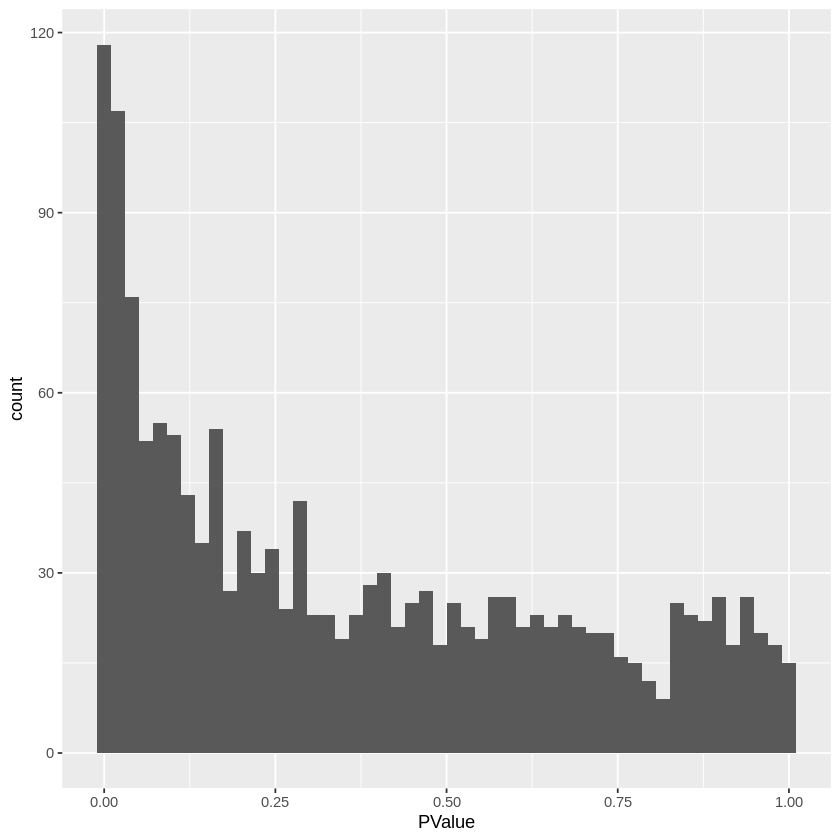

In [8]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

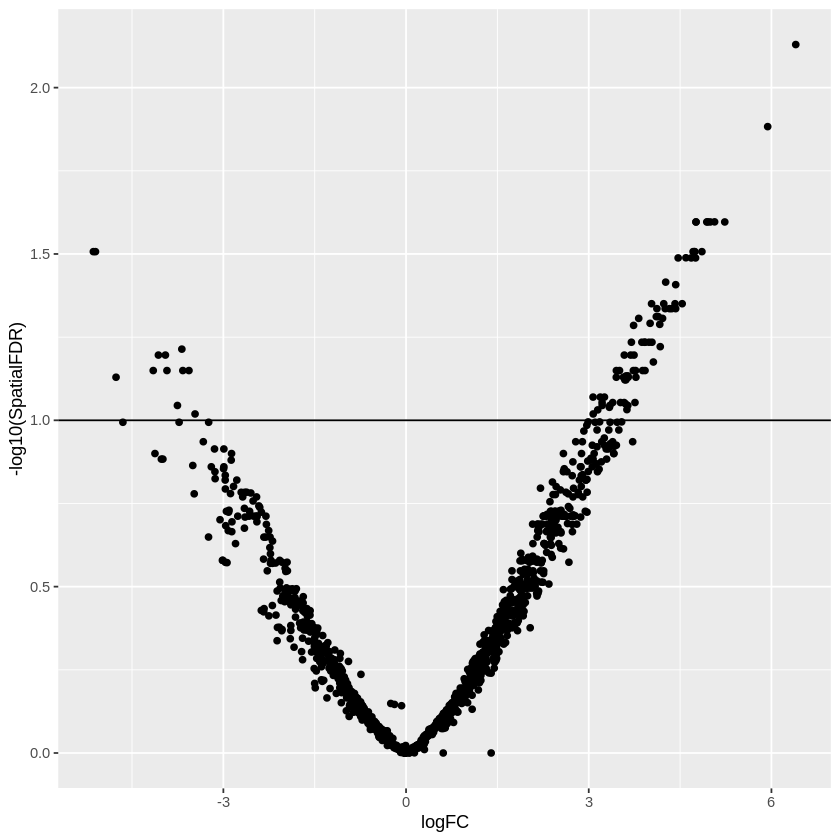

In [9]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) +   geom_point() +  geom_hline(yintercept = 1) 

In [10]:
milo_obj = buildNhoodGraph(milo_obj)
colData(milo_obj)

DataFrame with 20321 rows and 57 columns
                                 orig.ident nCount_RNA nFeature_RNA
                                   <factor>  <numeric>    <integer>
mus_SNuc7468112-TGATTTCTCTTGAGGT  musc_loom       8120         2211
mus_SNuc7468112-CCTTACGCAAGTTGTC  musc_loom       6826         2452
mus_SNuc7468112-ATAGACCGTGCAGGTA  musc_loom       6109         1490
mus_SNuc7468112-TGACTAGTCCTGTACC  musc_loom       5746         1830
mus_SNuc7468112-TCAGATGTCAACGGCC  musc_loom       5581         1632
...                                     ...        ...          ...
WS_A_SKM9845426-GCTCAAAGTTGTAAAG  musc_loom       8646         2137
WS_A_SKM9845426-ATTCCTAAGGCGTCCT  musc_loom       8141         2363
WS_A_SKM9845426-CATCGTCAGTTTCGAC  musc_loom       8099         2129
WS_A_SKM9845426-AGCGTATAGTTAGTGA  musc_loom       7503         2233
WS_A_SKM9845426-AGCATCAGTTACACAC  musc_loom       5815         1687
                                        SampleID          barcode
         

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



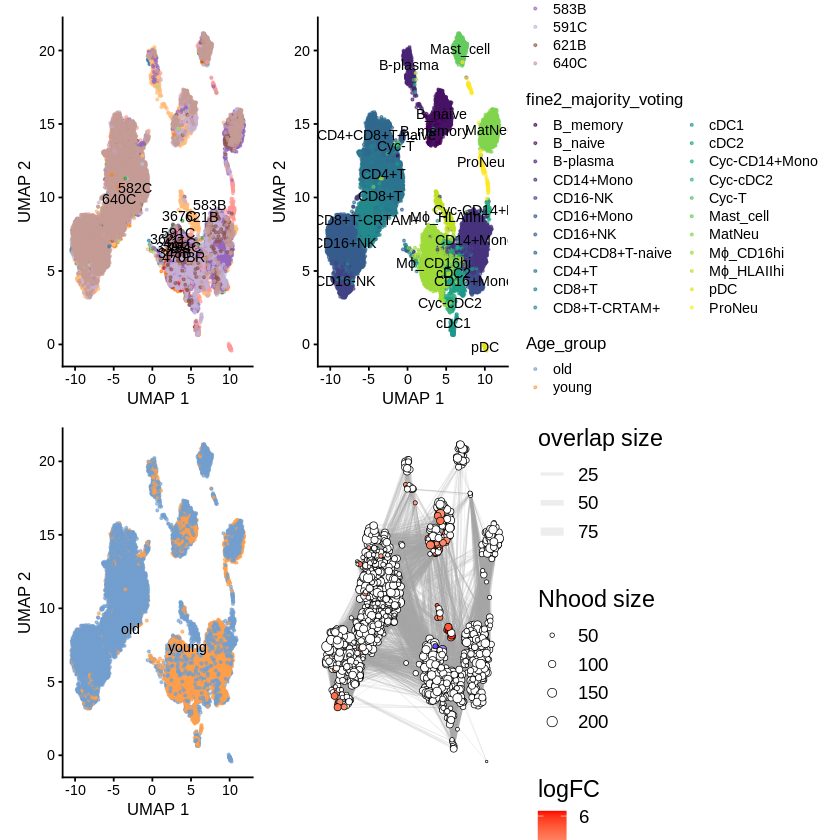

In [11]:
## Plot single-cell UMAP
umap_pl1 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", text_by = "DonorID", text_size = 3, point_size=0.5) +  guides(fill="none")
umap_pl2 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="fine2_majority_voting", text_by = "fine2_majority_voting", text_size = 3, point_size=0.5) +  guides(fill="none")
umap_pl3 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="Age_group", text_by = "Age_group", text_size = 3, point_size=0.5) +  guides(fill="none")

# str(milo_obj)
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(milo_obj, da_results, layout="UMAP",alpha=0.1) + scale_fill_gradient2(name = "logFC", low = "blue", high = "red") 

nh_plt_comb = umap_pl1+umap_pl2+umap_pl3 + nh_graph_pl + plot_layout(guides="collect")
nh_plt_comb

In [12]:
ggsave(filename = "./figure/human_SKM_v2_Immune_moli_v3_r_1.png", plot = nh_plt_comb, width = 10, height = 10)

In [13]:
da_results <- annotateNhoods(milo_obj, da_results, coldata_col = "fine2_majority_voting")
head(da_results)

Converting fine2_majority_voting to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.4291185,9.507683,0.18329401,0.6685611,0.8467337,1,0.8422019,CD4+T,0.8000000
2,-0.2598361,10.072109,0.07624469,0.7824547,0.9105898,2,0.9068841,Mϕ_CD16hi,0.9855072
3,-2.3013959,10.555679,4.69329764,0.0302895,0.2055114,3,0.1941459,CD14+Mono,0.8909091
4,-1.8917327,9.634767,1.92449485,0.1653738,0.4406738,4,0.4282926,CD4+T,0.8688525
5,1.0415103,9.724177,1.07818839,0.2991128,0.5811875,5,0.5715731,CD8+T-CRTAM+,0.8070175
6,-0.3278439,10.740712,0.08734455,0.7675829,0.9001068,6,0.8962547,CD4+T,0.6826087


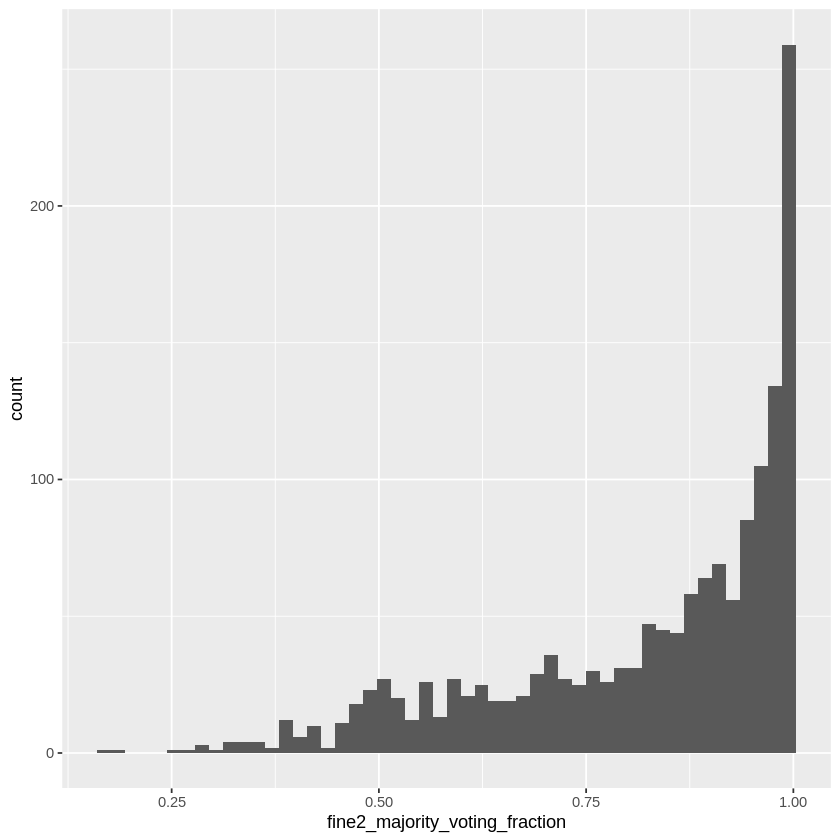

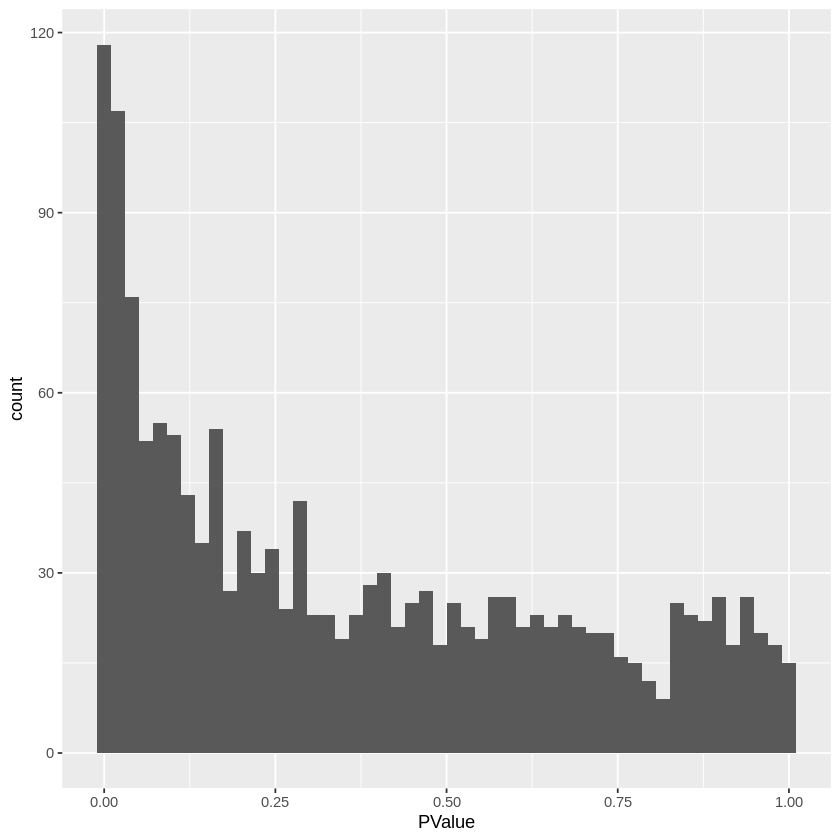

In [14]:
ggplot(da_results, aes(fine2_majority_voting_fraction)) + geom_histogram(bins=50)
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

In [15]:
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.4291185,9.507683,0.18329401,0.6685611,0.8467337,1,0.8422019,CD4+T,0.8000000
2,-0.2598361,10.072109,0.07624469,0.7824547,0.9105898,2,0.9068841,Mϕ_CD16hi,0.9855072
3,-2.3013959,10.555679,4.69329764,0.0302895,0.2055114,3,0.1941459,CD14+Mono,0.8909091
4,-1.8917327,9.634767,1.92449485,0.1653738,0.4406738,4,0.4282926,CD4+T,0.8688525
5,1.0415103,9.724177,1.07818839,0.2991128,0.5811875,5,0.5715731,CD8+T-CRTAM+,0.8070175
6,-0.3278439,10.740712,0.08734455,0.7675829,0.9001068,6,0.8962547,CD4+T,0.6826087


In [16]:
da_results$fine2_majority_voting_clean <- ifelse(da_results$fine2_majority_voting_fraction < 0.7, "Mixed", da_results$fine2_majority_voting)

In [17]:
table(da_results$fine2_majority_voting_clean)


       B_memory         B_naive        B-plasma       CD14+Mono         CD16-NK 
             23              50              21             149              25 
      CD16+Mono         CD16+NK CD4+CD8+T-naive           CD4+T           CD8+T 
             23             220              45             194              14 
   CD8+T-CRTAM+            cDC1            cDC2   Cyc-CD14+Mono       Mast_cell 
             79               5              27               1              28 
         MatNeu           Mixed       Mϕ_CD16hi      Mϕ_HLAIIhi             pDC 
             64             363             178              16               1 
         ProNeu 
              9 

In [19]:
# 'Cyc-CD14+Mono','Cyc-cDC2','MatNeu','Mϕ_HLAIIhi','pDC','ProNeu'
cell_type = c('B_naive','B_memory','B-plasma','CD16-NK','CD16+NK','CD4+CD8+T-naive','CD4+T','CD8+T','CD8+T-CRTAM+','CD14+Mono','CD16+Mono','Mϕ_CD16hi','cDC1','cDC2','Mast_cell','MatNeu','Mϕ_HLAIIhi','pDC','ProNeu')

In [20]:
da_results$fine2_majority_voting_clean <- factor(da_results$fine2_majority_voting_clean, levels=cell_type, ordered=TRUE)

In [21]:
library(ggbeeswarm)

In [22]:
da_results_clean1 = da_results[da_results$fine2_majority_voting_clean %in% c('B_naive','B_memory','B-plasma','CD16-NK','CD16+NK','CD4+CD8+T-naive','CD4+T','CD8+T','CD8+T-CRTAM+','CD14+Mono','CD16+Mono','Mϕ_CD16hi','cDC1','cDC2','Mast_cell','MatNeu','Mϕ_HLAIIhi','pDC','ProNeu'),]
da_results_clean2 = da_results[da_results$fine2_majority_voting_clean %in% c('B_naive','B_memory','B-plasma','CD16-NK','CD16+NK','CD4+CD8+T-naive','CD4+T','CD8+T','CD8+T-CRTAM+','CD14+Mono','CD16+Mono','Mϕ_CD16hi','cDC1','cDC2','Mast_cell'),]

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



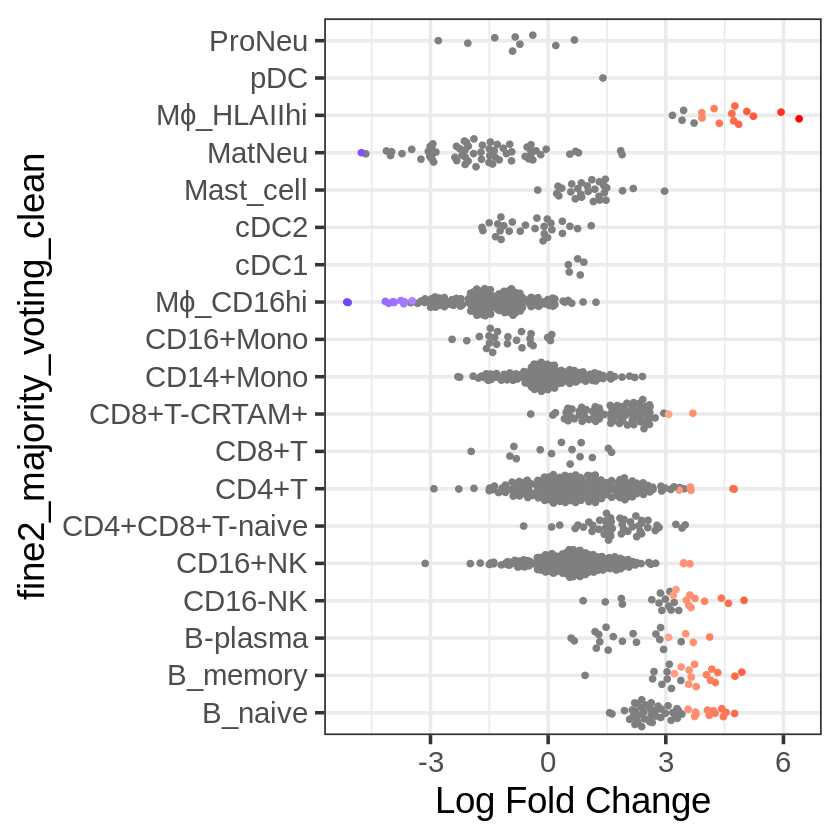

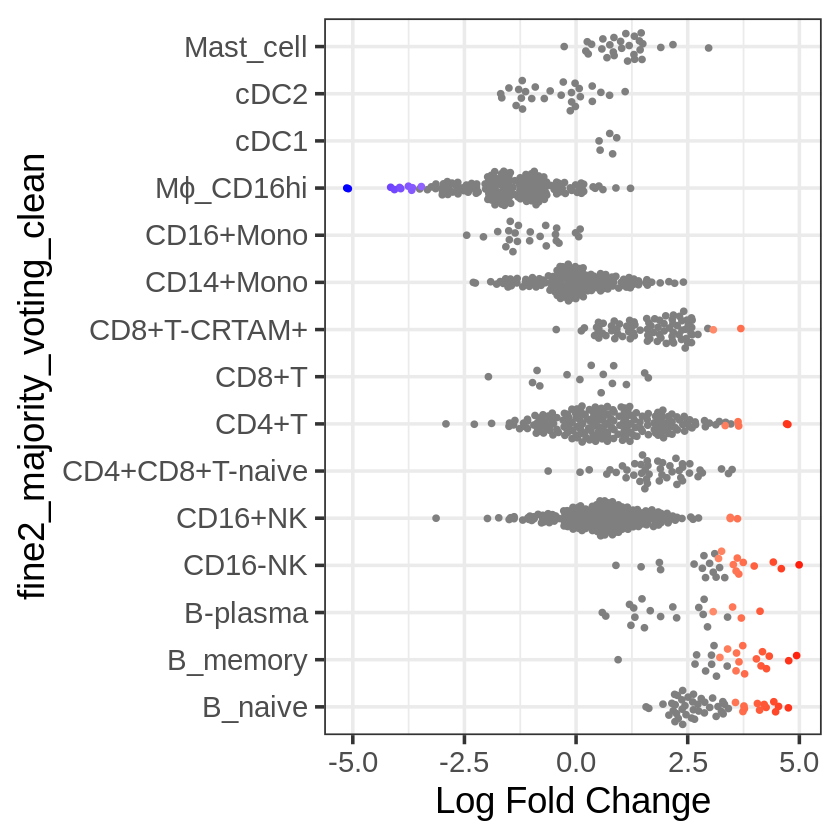

In [23]:
difab_plot = plotDAbeeswarm(da_results_clean1, group.by ="fine2_majority_voting_clean") +scale_color_gradient2(low = ("blue"), high = ("red"))
difab_plot
difab_plot_rm = plotDAbeeswarm(da_results_clean2, group.by ="fine2_majority_voting_clean") +scale_color_gradient2(low = ("blue"), high = ("red")) 
difab_plot_rm

Code to remove Donor specific neughbourhoods

In [18]:
da_results2 <- annotateNhoods(milo_obj, da_results, coldata_col = "DonorID")
head(da_results2)

Converting DonorID to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.4291185,9.507683,0.18329401,0.6685611,0.8467337,1,0.8422019,CD4+T,0.8000000,CD4+T,640C,0.4222222
2,-0.2598361,10.072109,0.07624469,0.7824547,0.9105898,2,0.9068841,Mϕ_CD16hi,0.9855072,Mϕ_CD16hi,362C,0.2753623
3,-2.3013959,10.555679,4.69329764,0.0302895,0.2055114,3,0.1941459,CD14+Mono,0.8909091,CD14+Mono,583B,0.4272727
4,-1.8917327,9.634767,1.92449485,0.1653738,0.4406738,4,0.4282926,CD4+T,0.8688525,CD4+T,640C,0.5081967
5,1.0415103,9.724177,1.07818839,0.2991128,0.5811875,5,0.5715731,CD8+T-CRTAM+,0.8070175,CD8+T-CRTAM+,640C,0.3157895
6,-0.3278439,10.740712,0.08734455,0.7675829,0.9001068,6,0.8962547,CD4+T,0.6826087,Mixed,640C,0.6217391


Plot distribution of max donor percentage across all neighbourhoods

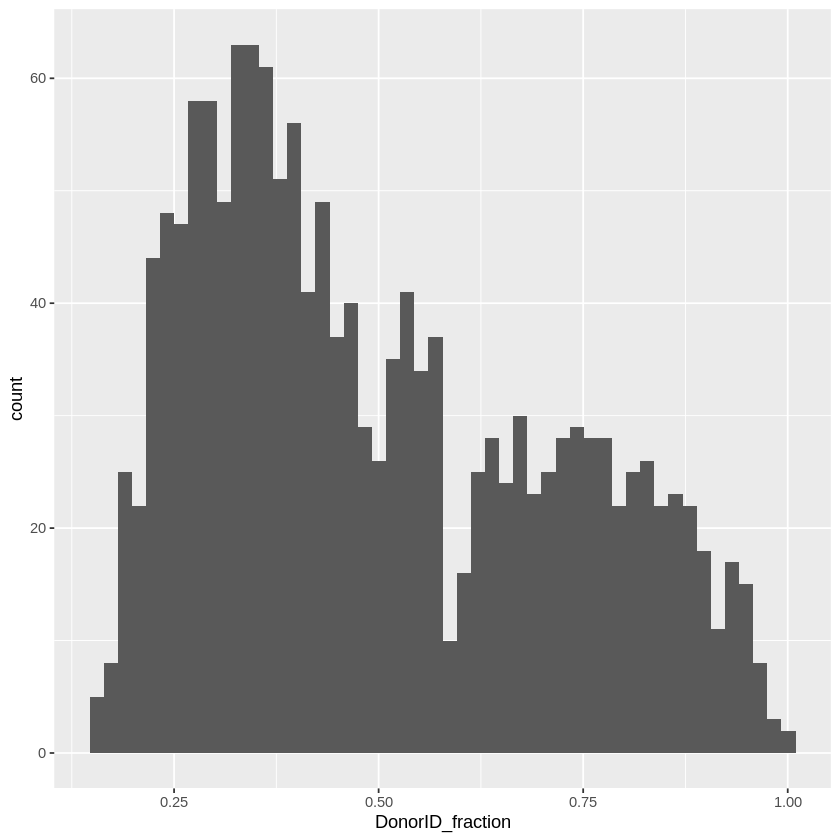

In [24]:
ggplot(da_results2, aes(DonorID_fraction)) + geom_histogram(bins=50)

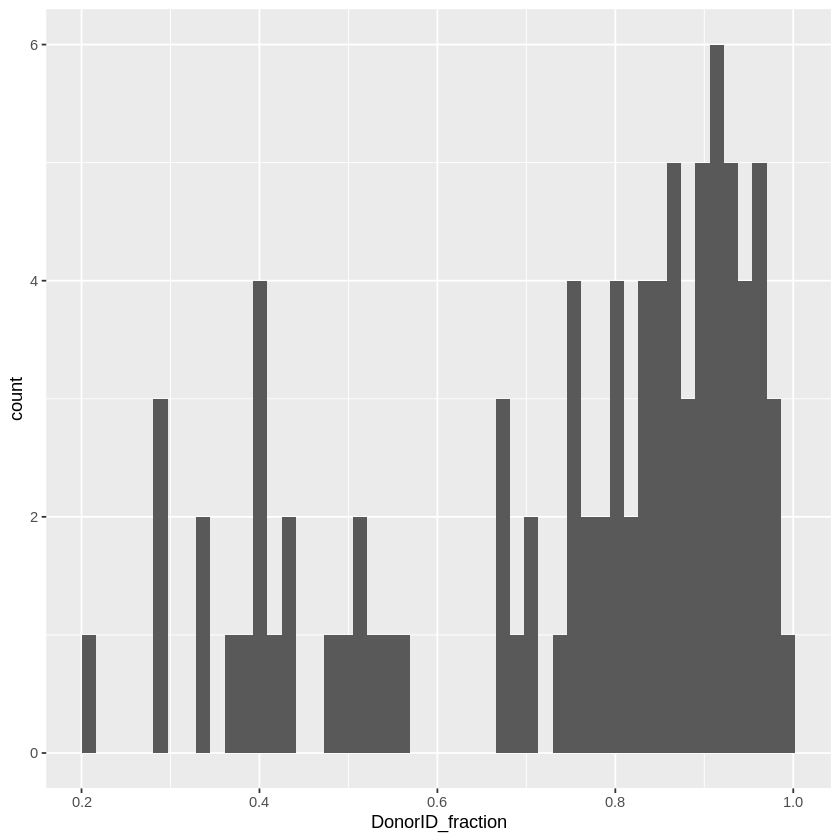

In [25]:
ggplot(da_results2[da_results2$SpatialFDR<0.1,], aes(DonorID_fraction)) + geom_histogram(bins=50)

Do not display neighbourhoods that have contain more than 90 % cells from one donor on the milo beeswarm plot

In [26]:
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.4291185,9.507683,0.18329401,0.6685611,0.8467337,1,0.8422019,CD4+T,0.8000000,CD4+T,640C,0.4222222
2,-0.2598361,10.072109,0.07624469,0.7824547,0.9105898,2,0.9068841,Mϕ_CD16hi,0.9855072,Mϕ_CD16hi,362C,0.2753623
3,-2.3013959,10.555679,4.69329764,0.0302895,0.2055114,3,0.1941459,CD14+Mono,0.8909091,CD14+Mono,583B,0.4272727
4,-1.8917327,9.634767,1.92449485,0.1653738,0.4406738,4,0.4282926,CD4+T,0.8688525,CD4+T,640C,0.5081967
5,1.0415103,9.724177,1.07818839,0.2991128,0.5811875,5,0.5715731,CD8+T-CRTAM+,0.8070175,CD8+T-CRTAM+,640C,0.3157895
6,-0.3278439,10.740712,0.08734455,0.7675829,0.9001068,6,0.8962547,CD4+T,0.6826087,Mixed,640C,0.6217391


In [27]:
da_results2$annotation_level1_clean = da_results2$fine2_majority_voting_clean

In [28]:
da_results2$annotation_level1_clean2 <- ifelse(da_results2$DonorID_fraction > 0.9, "Donor-specific", da_results2$annotation_level1_clean)

In [29]:
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction,annotation_level1_clean,annotation_level1_clean2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,-0.4291185,9.507683,0.18329401,0.6685611,0.8467337,1,0.8422019,CD4+T,0.8000000,CD4+T,640C,0.4222222,CD4+T,CD4+T
2,-0.2598361,10.072109,0.07624469,0.7824547,0.9105898,2,0.9068841,Mϕ_CD16hi,0.9855072,Mϕ_CD16hi,362C,0.2753623,Mϕ_CD16hi,Mϕ_CD16hi
3,-2.3013959,10.555679,4.69329764,0.0302895,0.2055114,3,0.1941459,CD14+Mono,0.8909091,CD14+Mono,583B,0.4272727,CD14+Mono,CD14+Mono
4,-1.8917327,9.634767,1.92449485,0.1653738,0.4406738,4,0.4282926,CD4+T,0.8688525,CD4+T,640C,0.5081967,CD4+T,CD4+T
5,1.0415103,9.724177,1.07818839,0.2991128,0.5811875,5,0.5715731,CD8+T-CRTAM+,0.8070175,CD8+T-CRTAM+,640C,0.3157895,CD8+T-CRTAM+,CD8+T-CRTAM+
6,-0.3278439,10.740712,0.08734455,0.7675829,0.9001068,6,0.8962547,CD4+T,0.6826087,Mixed,640C,0.6217391,Mixed,Mixed


In [30]:
table(da_results2$annotation_level1_clean2)


       B_memory         B_naive        B-plasma       CD14+Mono         CD16-NK 
             18              45              19             149              24 
      CD16+Mono         CD16+NK CD4+CD8+T-naive           CD4+T           CD8+T 
             23             213              45             177              14 
   CD8+T-CRTAM+            cDC1            cDC2   Cyc-CD14+Mono  Donor-specific 
             79               5              27               1              62 
      Mast_cell          MatNeu           Mixed       Mϕ_CD16hi          ProNeu 
             28              57             362             178               9 

In [31]:
cell_type

[1] "B_naive"         "B_memory"        "B-plasma"        "CD16-NK"        
 [5] "CD16+NK"         "CD4+CD8+T-naive" "CD4+T"           "CD8+T"          
 [9] "CD8+T-CRTAM+"    "CD14+Mono"       "CD16+Mono"       "Mϕ_CD16hi"      
[13] "cDC1"            "cDC2"            "Mast_cell"       "MatNeu"         
[17] "Mϕ_HLAIIhi"      "pDC"             "ProNeu"

In [32]:
da_results2$annotation_level1_clean2 = factor(da_results2$annotation_level1_clean2, levels = 
                                             c(cell_type,'Cyc-CD14+Mono', 'Mixed',"Donor-specific"))

In [33]:
figures_path = './figure/'
tables_path = './table/'

In [34]:
da_results2_clean1 = da_results2[da_results2$annotation_level1_clean2 %in% c('B_naive','B_memory','B-plasma','CD16-NK','CD16+NK','CD4+CD8+T-naive','CD4+T','CD8+T','CD8+T-CRTAM+','CD14+Mono','CD16+Mono','Mϕ_CD16hi','cDC1','cDC2','Mast_cell'),]

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <cf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <95>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <cf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <95>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <cf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“con

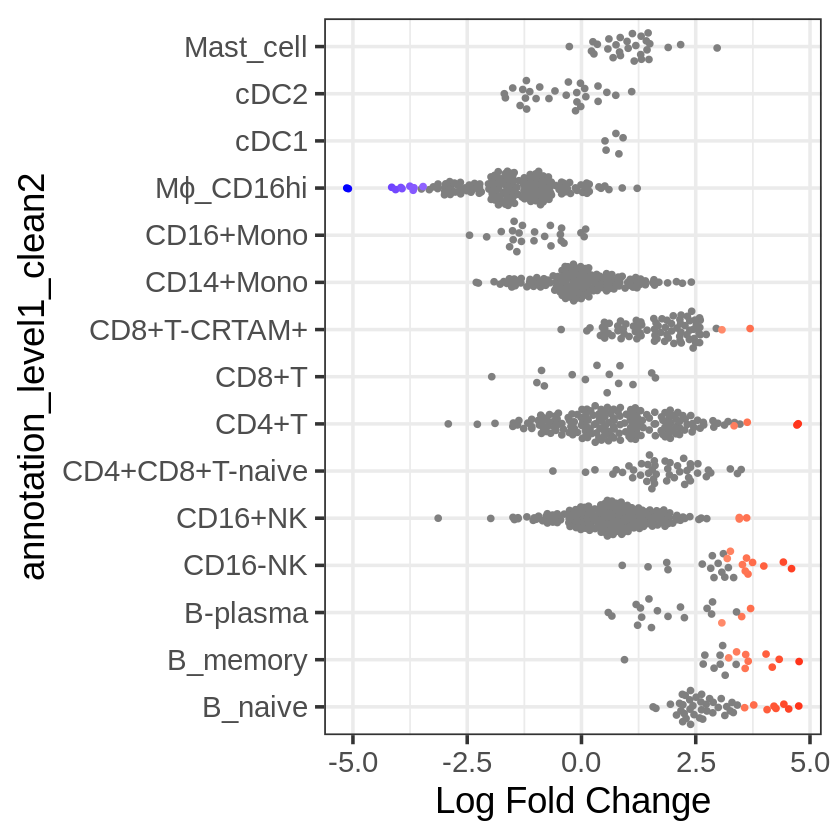

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <cf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <95>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <cf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <95>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <cf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Mϕ_CD16hi' in 'mbcsToSbcs': dot substituted for <95>”
Warning message in grid.Call(C_textBound

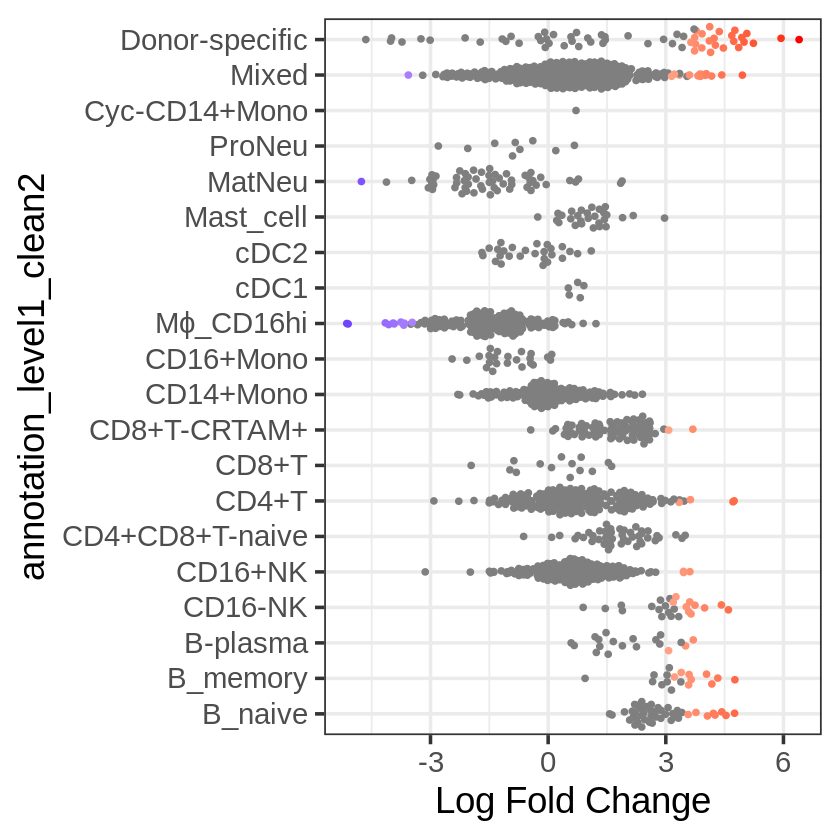

In [35]:
difab_plot_rm = plotDAbeeswarm(da_results2_clean1,  
                            group.by ="annotation_level1_clean2") +scale_color_gradient2(low = ("blue"), high = ("red"))
difab_plot_rm
ggsave(filename = paste0(figures_path, "human_SKM_v2_Immune_moli_v3_r_Donorfilt.pdf"), plot = difab_plot_rm, width = 6, height = 5)

difab_plot_all = plotDAbeeswarm(da_results2, group.by ="annotation_level1_clean2") +scale_color_gradient2(low = ("blue"), high = ("red")) 
difab_plot_all
ggsave(filename = paste0(figures_path, "human_SKM_v2_Immune_moli_v3_r_all.pdf"), plot = difab_plot_all, width = 6, height = 5)

Change LogFC to 0 for Donor-specific and Mixed neighbourhoods (won't be displayed on umap)

In [36]:
da_results2$logFC2 = ifelse(da_results2$annotation_level1_clean2 %in% c('Mixed', 'Donor-specific'), 0, da_results2$logFC)

In [37]:
milo_obj = buildNhoodGraph(milo_obj)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



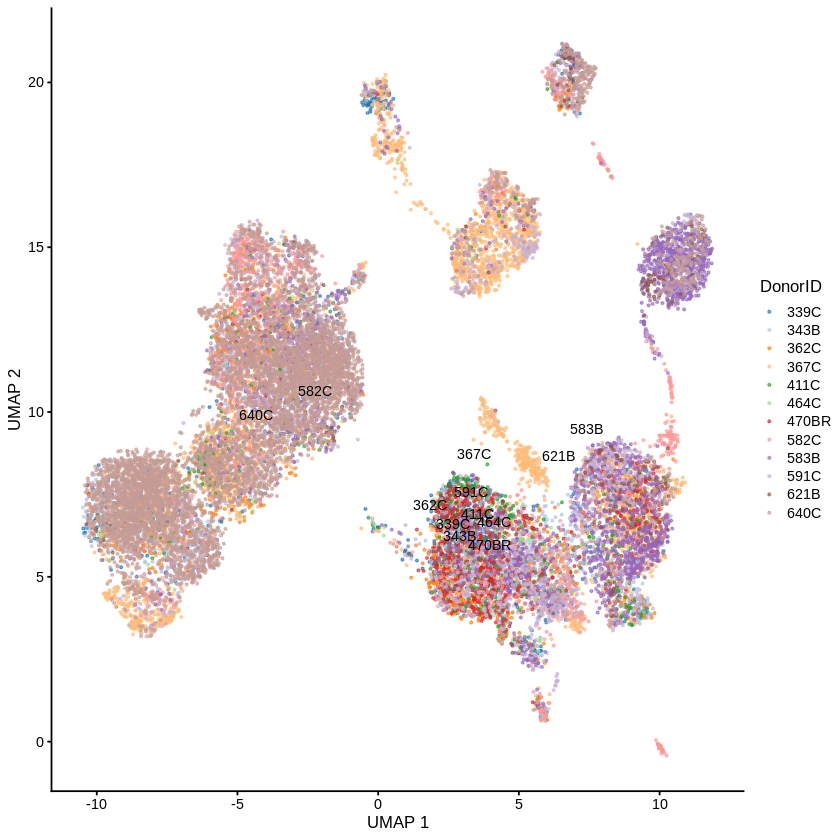

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



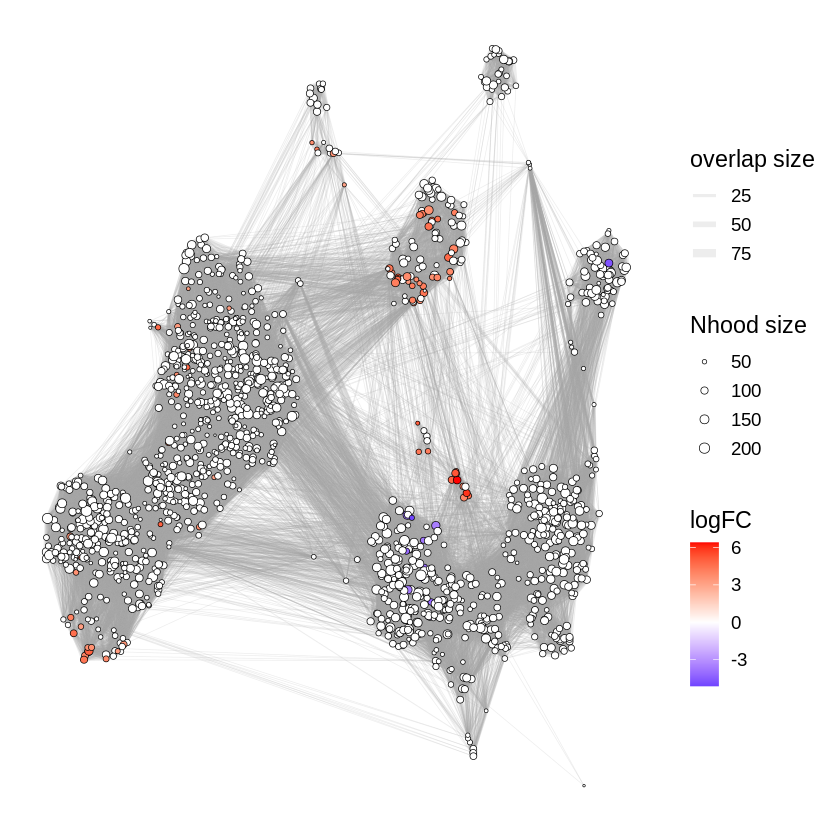

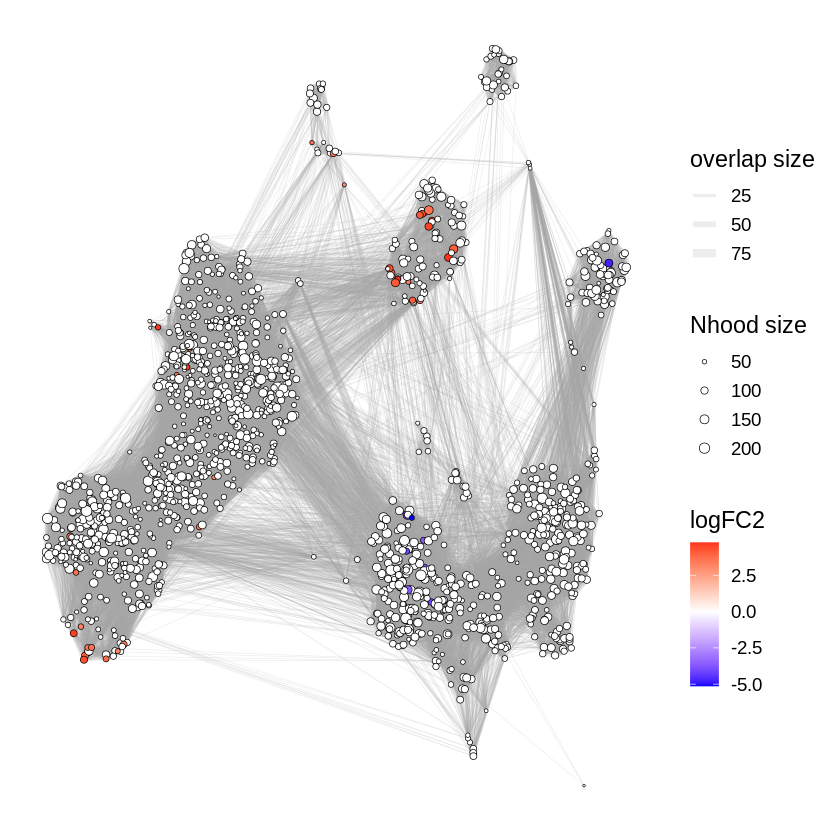

In [38]:
umap_pl <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", 
                           text_by = "DonorID",text_size = 3, point_size=0.5) +
  guides(fill="none")
umap_pl

ggsave(paste0(figures_path, "human_SKM_v2_Immune_moli_v3_rdonor.pdf"), umap_pl, width = 4, height = 3.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are kept in)
nh_graph_pl1 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1) + 
scale_fill_gradient2(name = "logFC", low = ("blue"), high = ("red")) 
nh_graph_pl1
ggsave(paste0(figures_path, "human_SKM_v2_Immune_moli_v3_r_nhds.pdf"), nh_graph_pl1, width = 4, height = 3.5)
ggsave(paste0(figures_path, "human_SKM_v2_Immune_moli_v3_r_nhds.png"), nh_graph_pl1, width = 4, height = 3.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are removed)
nh_graph_pl2 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1, res_column = "logFC2") + 
scale_fill_gradient2(name = "logFC2", low = ("blue"), high = ("red"))

nh_graph_pl2
ggsave(paste0(figures_path, "human_SKM_v2_Immune_moli_v3_r_nhds_filt.pdf"), nh_graph_pl2, width = 4, height = 3.5)
ggsave(paste0(figures_path, "human_SKM_v2_Immune_moli_v3_r_nhds_filt.png"), nh_graph_pl2, width = 4, height = 3.5)
#nh_plt_comb = umap_pl + nh_graph_pl1 +nh_graph_pl2
#  plot_layout(guides="collect")

In [39]:
fwrite(da_results2, file = paste0(tables_path,"human_SKM_v2_Immune_moli_v3_r_all.csv"))